# Results intersections #

### Parameters ###
Will be overriden by results_intersections.yaml

In [1]:
#Parameters
threshold = 0.3
min_main_repeats = 9
min_other_repeats = 3
trait = "lifespan"
life_history = ["lifespan", "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
debug_local = True

In [2]:
from pathlib import Path
import sys
import inspect

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '/data/sources/yspecies/notebooks', '/data/miniconda3/envs/yspecies/lib/python38.zip', '/data/miniconda3/envs/yspecies/lib/python3.8', '/data/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython']


In [3]:
from typing import *
from yspecies import *
from yspecies.workflow import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.config import *

In [4]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Load pathes ###

In [6]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

In [7]:
all_genes = locations.input.genes
external = locations.output.external 
intersections = locations.output.intersections
shap = external.shap
linear = external.linear
causality = external.dir / "causality"
folder = linear / f"R2_THRESHOLD_{int(threshold * 100)}"

In [8]:
#genes_meta = pd.read_csv(all_genes.genes_meta, sep="\t")
#genes_meta.head(10)

In [9]:
stage_one = locations.output.stage_one
stage_two = locations.output.stage_two
(stage_one, stage_two)

(PosixPath('../data/output/stage_1'), PosixPath('../data/output/stage_2'))

### Function to mark pro and anti genes ###

In [10]:
#used to evaluate the direction
def mark_direction(row, threshold: float, column: str = "mean_kendall_tau", max_repeats: int = 10):    
    cor = row[column] / max_repeats * row["repeats"]
    if cor >= threshold * 2:
        return "strong pro"
    if cor >= threshold:
        return "pro"
    elif cor > 0.0:
        return "weak pro"
    elif round(cor, 4) == 0.0:
        return "neutral"
    elif cor >= -threshold:
        return "weak anti"
    elif cor <= -threshold * 2:
        return "strong anti"
    else:
        return "anti"

## Summarize lifespan results by lifehistories ##

In [11]:
value_cols = ['repeats', 'mean_abs_shap', 'mean_kendall_tau']
value_cols_directed = value_cols + ["direction"]
cols = ['reference_gene','symbol'] + value_cols
cols

['reference_gene', 'symbol', 'repeats', 'mean_abs_shap', 'mean_kendall_tau']

In [12]:
def load_trait(path: Path, cols: list, min_repeats = 1):
    df = pd.read_csv(path, sep="\t")[cols].set_index("reference_gene")
    df = df[df.repeats >= min_repeats]
    df["direction"] = df.apply(lambda row: mark_direction(row, threshold=threshold), axis=1)
    return df

## Causality ##

In [13]:
causal = pd.read_csv(causality / "causal_selection.tsv", sep="\t").rename(columns={"Gene Code" : "reference_gene", "Gene Name": "symbol", "Relative Frequency": "frequency"}).set_index("reference_gene")
causal = causal[causal.frequency > 0.0]
causal

,symbol,frequency
reference_gene,,
ENSG00000188747,NOXA1,1.000
ENSG00000198663,C6orf89,0.940
ENSG00000115488,NEU2,0.940
ENSG00000184983,NDUFA6,0.900
ENSG00000151962,RBM46,0.820
ENSG00000171121,KCNMB3,0.720
ENSG00000170835,CEL,0.600
ENSG00000136436,CALCOCO2,0.420
ENSG00000129187,DCTD,0.400


In [14]:
main_trait_stage_1 = load_trait(stage_one / f"{trait}_selected.tsv", cols, 1)
main_trait_stage_2 = load_trait(stage_two / f"{trait}.tsv", cols, min_main_repeats)

main_trait_stage_2_causal = main_trait_stage_2.reset_index().merge(causal.reset_index(), on=["reference_gene", "symbol"], how="outer").set_index("reference_gene")

main_trait = main_trait_stage_2_causal.join(main_trait_stage_1[value_cols_directed], rsuffix=f"_{trait}_stage_1")
#print(main_trait.shape)
main_trait

,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction,frequency,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1
reference_gene,,,,,,,,,,
ENSG00000010219,DYRK4,10.000,3.178,0.357,pro,nan,10.000,2.384,0.325,pro
ENSG00000204498,NFKBIL1,10.000,2.261,-0.476,anti,nan,10.000,1.859,-0.128,weak anti
ENSG00000167515,TRAPPC2L,10.000,2.231,-0.342,anti,nan,10.000,1.543,-0.279,weak anti
ENSG00000105672,ETV2,10.000,1.197,0.682,strong pro,nan,10.000,1.018,0.713,strong pro
ENSG00000106554,CHCHD3,10.000,1.076,-0.510,anti,nan,6.000,0.540,-0.387,weak anti
ENSG00000066923,STAG3,10.000,0.922,0.495,pro,nan,9.000,0.962,0.480,pro
ENSG00000170835,CEL,10.000,0.849,0.746,strong pro,0.600,10.000,1.068,0.693,strong pro
ENSG00000185880,TRIM69,10.000,0.785,-0.120,weak anti,nan,10.000,0.942,0.097,weak pro
ENSG00000092529,CAPN3,10.000,0.719,0.580,pro,0.320,4.000,0.365,0.414,weak pro


In [15]:
other_life_history = [t for t in life_history if not t == trait]
other_traits = OrderedDict([(t, load_trait(stage_one / (t + "_selected.tsv"), cols, min_other_repeats)) for t in other_life_history])
other_traits["gestation_days"].head(10)

,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction
reference_gene,,,,,
ENSG00000006282,SPATA20,10.000,14.669,0.671,strong pro
ENSG00000171121,KCNMB3,10.000,7.212,0.635,strong pro
ENSG00000105672,ETV2,10.000,2.401,0.681,strong pro
ENSG00000188747,NOXA1,9.000,3.168,0.625,pro
ENSG00000165568,AKR1E2,9.000,2.615,-0.504,anti
ENSG00000101190,TCFL5,9.000,1.691,0.660,pro
ENSG00000172531,PPP1CA,9.000,1.284,-0.768,strong anti
ENSG00000066923,STAG3,8.000,5.666,0.430,pro
ENSG00000010219,DYRK4,8.000,2.100,0.454,pro


In [16]:
joined = main_trait
for t,v in other_traits.items():
    joined = joined.join(v, rsuffix = f"_{t}")#
#joined.to_csv(locations.output.stage_two / "lifespan_with_traits.tsv", sep="\t", index_label="reference_gene")
joined.columns

Index(['symbol', 'repeats', 'mean_abs_shap', 'mean_kendall_tau', 'direction',
       'frequency', 'repeats_lifespan_stage_1',
       'mean_abs_shap_lifespan_stage_1', 'mean_kendall_tau_lifespan_stage_1',
       'direction_lifespan_stage_1', 'symbol_mass_kg', 'repeats_mass_kg',
       'mean_abs_shap_mass_kg', 'mean_kendall_tau_mass_kg',
       'direction_mass_kg', 'symbol_mtGC', 'repeats_mtGC',
       'mean_abs_shap_mtGC', 'mean_kendall_tau_mtGC', 'direction_mtGC',
       'symbol_metabolic_rate', 'repeats_metabolic_rate',
       'mean_abs_shap_metabolic_rate', 'mean_kendall_tau_metabolic_rate',
       'direction_metabolic_rate', 'symbol_temperature', 'repeats_temperature',
       'mean_abs_shap_temperature', 'mean_kendall_tau_temperature',
       'direction_temperature', 'symbol_gestation_days',
       'repeats_gestation_days', 'mean_abs_shap_gestation_days',
       'mean_kendall_tau_gestation_days', 'direction_gestation_days'],
      dtype='object')

In [17]:
row = joined.iloc[0]
def summarize_life_history(row: pd.Series):   
    acc = []
    for t in other_life_history:
         rep = row[f"repeats_{t}"]
         if rep >= min_other_repeats:
           sh = row[f"mean_abs_shap_{t}"]
           tau = row[f"mean_kendall_tau_{t}"]
           direction = row[f"direction_{t}"]
           acc.append(f"{t} ({direction} | {int(rep)} | {round(sh,2)} | {round(tau,4)})")
    return ", ".join(acc)
summarize_life_history(row)

'mass_kg (weak pro | 3 | 0.12 | 0.2595), gestation_days (pro | 8 | 2.1 | 0.4539)'

In [18]:
joined["other_life_history_traits"] = joined.apply(summarize_life_history, axis=1)
shap_results = joined[main_trait.columns.to_list()+["other_life_history_traits"]]
shap_results.to_csv(locations.output.stage_two / "shap_results.tsv", sep="\t", index_label="reference_gene")
shap_results

,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction,frequency,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1,other_life_history_traits
reference_gene,,,,,,,,,,,
ENSG00000010219,DYRK4,10.000,3.178,0.357,pro,nan,10.000,2.384,0.325,pro,"mass_kg (weak pro | 3 | 0.12 | 0.2595), gestat..."
ENSG00000204498,NFKBIL1,10.000,2.261,-0.476,anti,nan,10.000,1.859,-0.128,weak anti,"mass_kg (weak anti | 4 | 0.2 | -0.1118), metab..."
ENSG00000167515,TRAPPC2L,10.000,2.231,-0.342,anti,nan,10.000,1.543,-0.279,weak anti,mtGC (anti | 7 | 0.02 | -0.4983)
ENSG00000105672,ETV2,10.000,1.197,0.682,strong pro,nan,10.000,1.018,0.713,strong pro,gestation_days (strong pro | 10 | 2.4 | 0.6806)
ENSG00000106554,CHCHD3,10.000,1.076,-0.510,anti,nan,6.000,0.540,-0.387,weak anti,metabolic_rate (weak anti | 3 | 0.0 | -0.3475)
ENSG00000066923,STAG3,10.000,0.922,0.495,pro,nan,9.000,0.962,0.480,pro,"mass_kg (weak pro | 4 | 0.26 | 0.2807), gestat..."
ENSG00000170835,CEL,10.000,0.849,0.746,strong pro,0.600,10.000,1.068,0.693,strong pro,
ENSG00000185880,TRIM69,10.000,0.785,-0.120,weak anti,nan,10.000,0.942,0.097,weak pro,
ENSG00000092529,CAPN3,10.000,0.719,0.580,pro,0.320,4.000,0.365,0.414,weak pro,


### Load linear ###

In [19]:
def lag_linear(df: pd.DataFrame)->pd.DataFrame:
    df["MLS_influence_linear"] = df.apply(lambda row: "pro" if row["maxlifespan_sign"]>0 else "anti", axis = 1)
    selected = df[["reference_gene","symbol","organ","maxlifespan_adjpval","maxlifespan_r2_adj", "MLS_influence_linear"]].sort_values(by="maxlifespan_r2_adj", ascending=False).drop_duplicates()
    selected["organ"] = selected.apply(lambda row: row["organ"] + " (" +row["MLS_influence_linear"]+" r^2=" + str(round(row["maxlifespan_r2_adj"],4)) +")", axis=1)
    return selected[["reference_gene","symbol","organ"]].groupby(["reference_gene", "symbol"], as_index=False).agg({'organ': ', '.join}).set_index("reference_gene")


In [20]:
linear_on_species = pd.read_csv(folder / "linear_models_on_species_vars.csv").rename(columns={"Unnamed: 0": "reference_gene"})
linear_on_species.head(10)

,reference_gene,symbol,organ,human_samples,maxlifespan_adjpval,maxlifespan_r2_adj,maxlifespan_n_obs,maxlifespan_sign,mass_adjpval,mass_r2_adj,mass_n_obs,mass_sign,temperature_adjpval,temperature_r2_adj,temperature_n_obs,temperature_sign,metabolicRate_adjpval,metabolicRate_r2_adj,metabolicRate_n_obs,metabolicRate_sign,gestation_adjpval,gestation_r2_adj,gestation_n_obs,gestation_sign,mtGC_adjpval,mtGC_r2_adj,mtGC_n_obs,mtGC_sign,maxlifespan_uniquely_associated,mass_uniquely_associated,temperature_uniquely_associated,metabolicRate_uniquely_associated,gestation_uniquely_associated,mtGC_uniquely_associated
0,ENSG00000242866,STRC,Brain,withoutHumans,0.000,0.465,97.000,1.000,0.818,-0.007,91.000,1.000,0.388,0.003,96.000,-1.000,0.777,-0.001,82.000,1.000,0.000,0.368,97.000,1.000,0.000,0.455,94.000,1.000,False,False,False,False,False,False
1,ENSG00000111335,OAS2,Brain,withoutHumans,0.000,0.359,99.000,1.000,0.322,0.027,92.000,1.000,0.937,-0.010,98.000,-1.000,0.089,0.090,83.000,1.000,0.000,0.220,99.000,1.000,0.000,0.239,96.000,1.000,False,False,False,False,False,False
2,ENSG00000158715,SLC45A3,Brain,withoutHumans,0.000,0.342,100.000,1.000,0.000,0.222,93.000,1.000,0.162,0.020,99.000,1.000,0.008,0.159,84.000,1.000,0.000,0.262,100.000,1.000,0.000,0.256,97.000,1.000,False,False,False,False,False,False
3,ENSG00000119403,PHF19,Brain,withoutHumans,0.000,0.507,98.000,1.000,0.403,0.019,91.000,1.000,0.064,0.041,97.000,1.000,0.717,0.004,82.000,1.000,0.000,0.323,98.000,1.000,0.000,0.421,95.000,1.000,False,False,False,False,False,False
4,ENSG00000047230,CTPS2,Brain,withoutHumans,0.000,0.391,98.000,-1.000,0.273,0.034,91.000,-1.000,0.951,-0.010,97.000,1.000,0.497,0.025,82.000,-1.000,0.000,0.227,98.000,-1.000,0.000,0.318,95.000,-1.000,False,False,False,False,False,False
5,ENSG00000127863,TNFRSF19,Brain,withoutHumans,0.000,0.403,99.000,-1.000,0.678,-0.000,92.000,-1.000,0.000,0.175,98.000,1.000,0.357,0.039,83.000,-1.000,0.000,0.310,99.000,-1.000,0.000,0.302,96.000,-1.000,False,False,False,False,False,False
6,ENSG00000203740,METTL11B,Brain,withoutHumans,0.000,0.354,100.000,-1.000,0.370,0.022,93.000,-1.000,0.801,-0.009,99.000,-1.000,0.667,0.008,84.000,-1.000,0.000,0.189,100.000,-1.000,0.013,0.091,97.000,-1.000,False,False,False,False,False,False
7,ENSG00000131730,CKMT2,Brain,withoutHumans,0.000,0.416,96.000,1.000,0.003,0.170,89.000,1.000,0.379,0.003,95.000,-1.000,0.453,0.030,80.000,1.000,0.000,0.352,96.000,1.000,0.000,0.276,93.000,1.000,False,False,False,False,False,False
8,ENSG00000099994,SUSD2,Brain,withoutHumans,0.000,0.518,99.000,-1.000,0.066,0.079,93.000,-1.000,0.018,0.069,98.000,1.000,0.116,0.080,84.000,-1.000,0.000,0.406,98.000,-1.000,0.000,0.288,96.000,-1.000,False,False,False,False,False,False
9,ENSG00000001036,FUCA2,Brain,withoutHumans,0.000,0.389,87.000,-1.000,0.397,0.021,85.000,-1.000,0.615,-0.006,86.000,-1.000,0.418,0.036,76.000,-1.000,0.000,0.309,87.000,-1.000,0.000,0.366,84.000,-1.000,False,False,False,False,False,False


In [21]:
max_linear = linear_on_species[["reference_gene", "maxlifespan_r2_adj"]].groupby("reference_gene").max().rename(columns={"maxlifespan_r2_adj": "max_linear_r2"})
max_linear.head(10)

,max_linear_r2
reference_gene,
ENSG00000000003,0.414
ENSG00000001036,0.389
ENSG00000001497,0.507
ENSG00000003402,0.348
ENSG00000003436,0.342
ENSG00000004139,0.476
ENSG00000004939,0.564
ENSG00000005073,0.318
ENSG00000005102,0.415


In [22]:
linear_organ = lag_linear(linear_on_species).join(max_linear)
linear_organ.head()

,symbol,organ,max_linear_r2
reference_gene,,,
ENSG00000000003,TSPAN6,Liver (pro r^2=0.4136),0.414
ENSG00000001036,FUCA2,"Brain (anti r^2=0.3894), Heart (anti r^2=0.3263)",0.389
ENSG00000001497,LAS1L,Heart (anti r^2=0.507),0.507
ENSG00000003402,CFLAR,Heart (pro r^2=0.3485),0.348
ENSG00000003436,TFPI,Brain (anti r^2=0.3418),0.342


# Join with linear models #

In [23]:
shap_with_causal_linear = shap_results.join(linear_organ[["organ","max_linear_r2"]])
shap_with_causal_linear.to_csv(locations.output.dir / "results" / "shap_with_causal_linear.tsv", sep="\t", index_label="reference_gene")
shap_with_causal_linear

,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction,frequency,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1,other_life_history_traits,organ,max_linear_r2
reference_gene,,,,,,,,,,,,,
ENSG00000010219,DYRK4,10.000,3.178,0.357,pro,nan,10.000,2.384,0.325,pro,"mass_kg (weak pro | 3 | 0.12 | 0.2595), gestat...",Heart (pro r^2=0.3529),0.353
ENSG00000204498,NFKBIL1,10.000,2.261,-0.476,anti,nan,10.000,1.859,-0.128,weak anti,"mass_kg (weak anti | 4 | 0.2 | -0.1118), metab...",NaN,nan
ENSG00000167515,TRAPPC2L,10.000,2.231,-0.342,anti,nan,10.000,1.543,-0.279,weak anti,mtGC (anti | 7 | 0.02 | -0.4983),"Brain (anti r^2=0.5246), Heart (anti r^2=0.3671)",0.525
ENSG00000105672,ETV2,10.000,1.197,0.682,strong pro,nan,10.000,1.018,0.713,strong pro,gestation_days (strong pro | 10 | 2.4 | 0.6806),NaN,nan
ENSG00000106554,CHCHD3,10.000,1.076,-0.510,anti,nan,6.000,0.540,-0.387,weak anti,metabolic_rate (weak anti | 3 | 0.0 | -0.3475),"Brain (anti r^2=0.4242), Heart (anti r^2=0.394)",0.424
ENSG00000066923,STAG3,10.000,0.922,0.495,pro,nan,9.000,0.962,0.480,pro,"mass_kg (weak pro | 4 | 0.26 | 0.2807), gestat...",NaN,nan
ENSG00000170835,CEL,10.000,0.849,0.746,strong pro,0.600,10.000,1.068,0.693,strong pro,,Brain (pro r^2=0.4815),0.481
ENSG00000185880,TRIM69,10.000,0.785,-0.120,weak anti,nan,10.000,0.942,0.097,weak pro,,NaN,nan
ENSG00000092529,CAPN3,10.000,0.719,0.580,pro,0.320,4.000,0.365,0.414,weak pro,,"Kidney (pro r^2=0.4455), Heart (pro r^2=0.4098)",0.446


# Genage annotations #

In [24]:
genage_folder = locations.input.annotations.genage

genage_conversions = pd.read_csv(genage_folder.conversion, sep="\t")
genage = genage_conversions[["Ensembl","Gene Symbol", "Organism", "Lifespan Effect", "Longevity Influence", "Method"]].drop_duplicates()
genage.head(5)

,Ensembl,Gene Symbol,Organism,Lifespan Effect,Longevity Influence,Method
0,YPL174C,NIP100,Saccharomyces cerevisiae,decrease,fitness,Deletion
1,YER091C,MET6,Saccharomyces cerevisiae,decrease,fitness,Deletion
2,YDR108W,TRS85,Saccharomyces cerevisiae,decrease,fitness,Deletion
4,YMR135C,GID8,Saccharomyces cerevisiae,decrease,fitness,Deletion
6,YCR024C-A,PMP1,Saccharomyces cerevisiae,decrease,fitness,Deletion


In [25]:
genage_genes = pd.read_csv(genage_folder.orthologs.dir / "all.tsv", sep="\t").rename(columns={"Homo_sapiens":"reference_gene"})
genage_genes.head(5)

,reference_gene,Caenorhabditis_elegans,Drosophila_melanogaster,Mus_musculus,Mesocricetus_auratus,Danio_rerio
0,ENSG00000242265,NaN,NaN,ENSMUSG00000092035,ENSMAUG00000018656,ENSDARG00000109342
1,ENSG00000139990,WBGene00011242,FBgn0250755,ENSMUSG00000049106,ENSMAUG00000004350,ENSDARG00000060320
2,ENSG00000073921,WBGene00006751,FBgn0086372,ENSMUSG00000039361,ENSMAUG00000011448,ENSDARG00000012866;ENSDARG00000014137
3,ENSG00000139687,WBGene00003020,NaN,ENSMUSG00000022105,ENSMAUG00000020865,ENSDARG00000006782
4,ENSG00000119977,WBGene00017120,NaN,ENSMUSG00000025008,ENSMAUG00000021808,NaN


In [26]:
genage_humanized = genage.head(0)
for c in genage_genes.columns[1:]:
    col = c.replace("_", " ")
    selected_genes = genage_genes[["reference_gene",c]].rename(columns = {c:"Ensembl"}).dropna()
    selected_genes["Ensembl"] = selected_genes.apply(lambda row: row["Ensembl"].split(";"),1)
    genage_org = genage[genage["Organism"]==col]
    merged = selected_genes.explode("Ensembl").merge(genage_org, on="Ensembl", how="inner")
    genage_humanized = pd.concat([genage_humanized, merged])
genage_humanized = genage_humanized.drop_duplicates()
genage_humanized.head(10)

,Ensembl,Gene Symbol,Organism,Lifespan Effect,Longevity Influence,Method,reference_gene
0,WBGene00006619,try-1,Caenorhabditis elegans,increase,anti,RNA interference,ENSG00000095917
1,WBGene00006619,try-1,Caenorhabditis elegans,increase,anti,RNA interference,ENSG00000116176
2,WBGene00006619,try-1,Caenorhabditis elegans,increase,anti,RNA interference,ENSG00000172236
3,WBGene00006619,try-1,Caenorhabditis elegans,increase,anti,RNA interference,ENSG00000197253
4,WBGene00004481,rps-12,Caenorhabditis elegans,increase,anti,Post-developmental RNA interference,ENSG00000112306
5,WBGene00004789,sgk-1,Caenorhabditis elegans,increase,anti,Deletion,ENSG00000101049
6,WBGene00004789,sgk-1,Caenorhabditis elegans,increase,anti,Deletion,ENSG00000104205
7,WBGene00003476,mtm-3,Caenorhabditis elegans,decrease,pro,RNA interference,ENSG00000087053
8,WBGene00003476,mtm-3,Caenorhabditis elegans,decrease,pro,RNA interference,ENSG00000063601
9,WBGene00003476,mtm-3,Caenorhabditis elegans,decrease,pro,RNA interference,ENSG00000003987


### Add genage human info ###

In [27]:
genage_human = pd.read_csv(genage_folder.human, sep='\t')
genage_human.shape

(307, 6)

### Check for genage genes ###

In [28]:
shap_with_causal_linear_genage_info = shap_with_causal_linear.merge(genage_humanized, on="reference_gene")
shap_with_causal_linear_genage_info.to_csv(locations.output.dir / "results" / "genage_intersection.tsv", index_label="reference_gene", sep="\t")
shap_with_causal_linear_genage_info

,reference_gene,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction,frequency,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1,other_life_history_traits,organ,max_linear_r2,Ensembl,Gene Symbol,Organism,Lifespan Effect,Longevity Influence,Method
0,ENSG00000162959,MEMO1,10.000,0.331,-0.609,strong anti,nan,nan,nan,nan,NaN,gestation_days (weak anti | 7 | 1.35 | -0.2135),"Heart (anti r^2=0.4534), Brain (anti r^2=0.444...",0.453,WBGene00016500,memo-1,Caenorhabditis elegans,increase,anti,Mutation
1,ENSG00000204231,RXRB,10.000,0.271,-0.534,anti,nan,4.000,0.097,-0.152,weak anti,,NaN,nan,WBGene00007547,nhr-154,Caenorhabditis elegans,increase,anti,RNA interference
2,ENSG00000164362,TERT,10.000,0.271,-0.599,anti,nan,4.000,0.119,-0.466,weak anti,"mtGC (weak anti | 5 | 0.02 | -0.517), gestatio...","Heart (anti r^2=0.4954), Liver (anti r^2=0.4836)",0.495,ENSMUSG00000021611,Tert,Mus musculus,increase,pro,Overexpression
3,ENSG00000164362,TERT,10.000,0.271,-0.599,anti,nan,4.000,0.119,-0.466,weak anti,"mtGC (weak anti | 5 | 0.02 | -0.517), gestatio...","Heart (anti r^2=0.4954), Liver (anti r^2=0.4836)",0.495,ENSMUSG00000021611,Tert,Mus musculus,increase,pro,Knockin
4,ENSG00000164362,TERT,10.000,0.271,-0.599,anti,nan,4.000,0.119,-0.466,weak anti,"mtGC (weak anti | 5 | 0.02 | -0.517), gestatio...","Heart (anti r^2=0.4954), Liver (anti r^2=0.4836)",0.495,ENSDARG00000042637,tert,Danio rerio,decrease,pro,Mutation
5,ENSG00000140398,NEIL1,10.000,0.219,0.788,strong pro,nan,2.000,0.022,0.661,weak pro,,NaN,nan,ENSMUSG00000032298,Neil1,Mus musculus,decrease,pro,Knockout
6,ENSG00000142937,RPS8,10.000,0.138,0.635,strong pro,nan,nan,nan,nan,NaN,mtGC (weak pro | 3 | 0.0 | 0.4755),NaN,nan,WBGene00004477,rps-8,Caenorhabditis elegans,increase,anti,RNA interference
7,ENSG00000175806,MSRA,10.000,0.059,-0.557,anti,nan,nan,nan,nan,NaN,metabolic_rate (weak anti | 4 | 0.64 | -0.0479),Kidney (anti r^2=0.3019),0.302,FBgn0000565,Eip71CD,Drosophila melanogaster,increase,pro,Overexpression
8,ENSG00000175806,MSRA,10.000,0.059,-0.557,anti,nan,nan,nan,nan,NaN,metabolic_rate (weak anti | 4 | 0.64 | -0.0479),Kidney (anti r^2=0.3019),0.302,ENSMUSG00000054733,Msra,Mus musculus,decrease,pro,Knockout
9,ENSG00000175806,MSRA,10.000,0.059,-0.557,anti,nan,nan,nan,nan,NaN,metabolic_rate (weak anti | 4 | 0.64 | -0.0479),Kidney (anti r^2=0.3019),0.302,ENSMUSG00000054733,Msra,Mus musculus,NaN,NaN,Mutations


In [29]:
shap_with_causal_linear_genage_info = shap_with_causal_linear_genage_info[["reference_gene"]].pivot_table(index=["reference_gene"], aggfunc='size')
shap_with_causal_linear_genage_info.name = "genage_count"
shap_with_causal_linear_genage = shap_with_causal_linear.join(shap_with_causal_linear_genage_info)
shap_with_causal_linear_genage['genage_count'] = shap_with_causal_linear_genage['genage_count'].fillna(0)
print(shap_with_causal_linear_genage.shape, shap_with_causal_linear.shape)
shap_with_causal_linear_genage.head(20)

(152, 14) (152, 13)


,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction,frequency,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1,other_life_history_traits,organ,max_linear_r2,genage_count
reference_gene,,,,,,,,,,,,,,
ENSG00000010219,DYRK4,10.000,3.178,0.357,pro,nan,10.000,2.384,0.325,pro,"mass_kg (weak pro | 3 | 0.12 | 0.2595), gestat...",Heart (pro r^2=0.3529),0.353,0.000
ENSG00000204498,NFKBIL1,10.000,2.261,-0.476,anti,nan,10.000,1.859,-0.128,weak anti,"mass_kg (weak anti | 4 | 0.2 | -0.1118), metab...",NaN,nan,0.000
ENSG00000167515,TRAPPC2L,10.000,2.231,-0.342,anti,nan,10.000,1.543,-0.279,weak anti,mtGC (anti | 7 | 0.02 | -0.4983),"Brain (anti r^2=0.5246), Heart (anti r^2=0.3671)",0.525,0.000
ENSG00000105672,ETV2,10.000,1.197,0.682,strong pro,nan,10.000,1.018,0.713,strong pro,gestation_days (strong pro | 10 | 2.4 | 0.6806),NaN,nan,0.000
ENSG00000106554,CHCHD3,10.000,1.076,-0.510,anti,nan,6.000,0.540,-0.387,weak anti,metabolic_rate (weak anti | 3 | 0.0 | -0.3475),"Brain (anti r^2=0.4242), Heart (anti r^2=0.394)",0.424,0.000
ENSG00000066923,STAG3,10.000,0.922,0.495,pro,nan,9.000,0.962,0.480,pro,"mass_kg (weak pro | 4 | 0.26 | 0.2807), gestat...",NaN,nan,0.000
ENSG00000170835,CEL,10.000,0.849,0.746,strong pro,0.600,10.000,1.068,0.693,strong pro,,Brain (pro r^2=0.4815),0.481,0.000
ENSG00000185880,TRIM69,10.000,0.785,-0.120,weak anti,nan,10.000,0.942,0.097,weak pro,,NaN,nan,0.000
ENSG00000092529,CAPN3,10.000,0.719,0.580,pro,0.320,4.000,0.365,0.414,weak pro,,"Kidney (pro r^2=0.4455), Heart (pro r^2=0.4098)",0.446,0.000


#### Saving results ####

In [37]:
shap_with_causal_linear_genage.to_csv(intersections / "intersections.tsv", sep = "\t", index = True)

# Ranking genes #

In [31]:
shap_ranked = shap_with_causal_linear_genage.copy()
shap_ranked.columns
rank_method = "dense"
na_rank = "bottom"
shap_ranked["shap_rank"] = shap_ranked.mean_abs_shap.rank(ascending=False,method=rank_method , na_option = na_rank)

shap_ranked['repeats_lifespan_stage_1'] =shap_ranked['repeats_lifespan_stage_1'].replace(np.nan, 0)
shap_ranked['frequency'] = shap_ranked['frequency'].replace(np.nan, 0)
shap_ranked['frequency_rank'] = shap_ranked['frequency'].rank(ascending=False, method=rank_method, na_option = na_rank)

shap_ranked["mean_kendall_tau"] = shap_ranked['mean_kendall_tau'].replace(np.nan, 0)
shap_ranked["kendall_tau_abs"] = shap_ranked['mean_kendall_tau'].abs()
shap_ranked["kendall_tau_rank"] = shap_ranked['kendall_tau_abs'].rank(ascending=False,method=rank_method,  na_option = na_rank )

shap_ranked["repeats_all"] = shap_ranked['repeats'] + shap_ranked['repeats_lifespan_stage_1']
shap_ranked["repeats_rank"] = shap_ranked["repeats_all"].rank(ascending=False,method=rank_method, na_option = na_rank )
shap_ranked["tissue_linear_rank"] = shap_ranked["max_linear_r2"].rank(ascending=False,method=rank_method, na_option = na_rank )

genage_num = (shap_ranked["genage_count"] > 0).sum()
shap_ranked["genage_rank"] = shap_ranked["genage_count"].apply(lambda l: genage_num if l <1 else 0)
#shap_ranked["genage_rank"] = (shap_ranked["genage_count"] < 0) + 1

shap_ranked["ranks_sum"] = shap_ranked["repeats_rank"] + shap_ranked["kendall_tau_rank"] + shap_ranked["shap_rank"] + shap_ranked["tissue_linear_rank"] + shap_ranked["genage_rank"] 
shap_ranked["rank"] =shap_ranked["ranks_sum"].rank(ascending=True, method=rank_method)

shap_ranked = shap_ranked.reindex(columns=['symbol',"rank","ranks_sum",
                                           "repeats_rank", 'shap_rank', "kendall_tau_rank", "frequency_rank", "tissue_linear_rank", "genage_rank",
                                           "repeats_all",  'repeats',  'mean_abs_shap', 'mean_kendall_tau', 'frequency', "max_linear_r2", "genage_count",
       'direction', 'repeats_lifespan_stage_1',
       'mean_abs_shap_lifespan_stage_1', 'mean_kendall_tau_lifespan_stage_1',
       'direction_lifespan_stage_1', 'other_life_history_traits', 'organ',])
shap_ranked = shap_ranked.sort_values(by="rank", ascending=True)
shap_ranked.to_csv(intersections / "intersections_ranked.tsv", sep = "\t", index = True)
shap_ranked.head(20)

,symbol,rank,ranks_sum,repeats_rank,shap_rank,kendall_tau_rank,frequency_rank,tissue_linear_rank,genage_rank,repeats_all,repeats,mean_abs_shap,mean_kendall_tau,frequency,max_linear_r2,genage_count,direction,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1,other_life_history_traits,organ
reference_gene,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000188747,NOXA1,1.000,57.000,2.000,12.000,16.000,1.000,10.000,17,19.000,10.000,0.507,0.697,1.000,0.627,0.000,strong pro,9.000,0.413,0.689,strong pro,"mtGC (pro | 8 | 0.05 | 0.649), gestation_days ...","Brain (pro r^2=0.6271), Kidney (pro r^2=0.6017..."
ENSG00000170835,CEL,2.000,65.000,1.000,7.000,7.000,6.000,33.000,17,20.000,10.000,0.849,0.746,0.600,0.481,0.000,strong pro,10.000,1.068,0.693,strong pro,,Brain (pro r^2=0.4815)
ENSG00000136436,CALCOCO2,3.000,74.000,7.000,27.000,5.000,7.000,18.000,17,14.000,10.000,0.307,0.763,0.420,0.559,0.000,strong pro,4.000,0.074,0.722,weak pro,,"Lung (pro r^2=0.5586), Brain (pro r^2=0.5369),..."
ENSG00000198663,C6orf89,4.000,75.000,10.000,35.000,1.000,2.000,12.000,17,10.000,10.000,0.226,-0.788,0.940,0.616,0.000,strong anti,0.000,nan,nan,NaN,metabolic_rate (anti | 6 | 0.0 | -0.5674),"Heart (anti r^2=0.6159), Liver (anti r^2=0.4011)"
ENSG00000172531,PPP1CA,5.000,80.000,5.000,42.000,3.000,20.000,13.000,17,16.000,10.000,0.165,-0.782,0.000,0.610,0.000,strong anti,6.000,0.093,-0.761,anti,gestation_days (strong anti | 9 | 1.28 | -0.7678),"Brain (anti r^2=0.6099), Heart (anti r^2=0.4668)"
ENSG00000006282,SPATA20,6.000,86.000,8.000,25.000,31.000,16.000,5.000,17,13.000,10.000,0.311,0.649,0.080,0.675,0.000,strong pro,3.000,0.148,0.608,weak pro,"mtGC (strong pro | 9 | 0.24 | 0.6937), gestati...","Brain (pro r^2=0.675), Heart (pro r^2=0.6381),..."
ENSG00000142002,DPP9,7.000,87.000,4.000,26.000,11.000,11.000,29.000,17,17.000,10.000,0.309,-0.717,0.300,0.507,0.000,strong anti,7.000,0.101,-0.716,anti,,"Lung (anti r^2=0.5074), Heart (anti r^2=0.3048)"
ENSG00000129187,DCTD,8.000,89.000,8.000,32.000,26.000,8.000,6.000,17,13.000,10.000,0.253,0.674,0.400,0.666,0.000,strong pro,3.000,0.149,0.632,weak pro,mtGC (weak pro | 4 | 0.01 | 0.6756),"Liver (pro r^2=0.6659), Heart (pro r^2=0.4353)..."
ENSG00000165501,LRR1,9.000,93.000,2.000,19.000,14.000,9.000,41.000,17,19.000,10.000,0.366,0.715,0.340,0.459,0.000,strong pro,9.000,0.177,0.688,strong pro,,"Heart (pro r^2=0.4585), Lung (pro r^2=0.4286),..."


In [32]:
by_abs = shap_ranked[["symbol","shap_rank", "mean_abs_shap"]].reset_index().sort_values("shap_rank")
print(f"with impact > 0.1 years {by_abs[by_abs.mean_abs_shap >= 0.1].shape[0]}")
print(f"with impact > 1 year {by_abs[by_abs.mean_abs_shap >= 1].shape[0]}, they are {by_abs[by_abs.mean_abs_shap >= 1].symbol.values}")

with impact > 0.1 years 57
with impact > 1 year 5, they are ['DYRK4' 'NFKBIL1' 'TRAPPC2L' 'ETV2' 'CHCHD3']


### Statistics ###

In [33]:
relevant_genes = shap_with_causal_linear_genage[shap_with_causal_linear_genage.mean_abs_shap >= 0.1]

In [34]:
",".join(relevant_genes[relevant_genes.mean_abs_shap >= 1].symbol.to_list())

'DYRK4,NFKBIL1,TRAPPC2L,ETV2,CHCHD3'

In [35]:
print("PRO GENES:")
print(f"strong pro genes: {relevant_genes[relevant_genes['direction'] =='strong pro'].shape[0]}")
print(f"pro genes: {relevant_genes[relevant_genes['direction'] == 'pro'].shape[0]}")
print(f"weak pro genes: {relevant_genes[relevant_genes['direction'] == 'weak pro'].shape[0]}")
print("\nANTI GENES:")
print(f"strong anti genes: {relevant_genes[relevant_genes['direction'] =='strong anti'].shape[0]}")
print(f"anti genes: {relevant_genes[relevant_genes['direction'] == 'anti'].shape[0]}")
print(f"weak anti genes: {relevant_genes[relevant_genes['direction'] == 'weak anti'].shape[0]}")
print(f">1 years{relevant_genes[relevant_genes.mean_abs_shap >= 1].symbol.values}")

PRO GENES:
strong pro genes: 16
pro genes: 10
weak pro genes: 2

ANTI GENES:
strong anti genes: 13
anti genes: 12
weak anti genes: 4
>1 years['DYRK4' 'NFKBIL1' 'TRAPPC2L' 'ETV2' 'CHCHD3']


Best kendall tau genes
======================

In [36]:
# >= 0.6 strong pro
# >= 0.3 pro
# > 0.0 weak pro
# < 0.0 weak anti
# <= -0.3 anti
# <= -0.6 strong anti
best_kendall_max = relevant_genes[relevant_genes.mean_kendall_tau >= 0.7].sort_values(by="mean_kendall_tau", ascending=False)[["symbol", "mean_kendall_tau"]]
best_kendall_min = relevant_genes[relevant_genes.mean_kendall_tau <= -0.7].sort_values(by="mean_kendall_tau", ascending=True)[["symbol", "mean_kendall_tau"]]
print(best_kendall_max.shape, best_kendall_min.shape)
print(f"with MAX [{', '.join(best_kendall_max.symbol.to_list())}] and \nMIN [{', '.join(best_kendall_min.symbol.to_list())}]")

(6, 2) (5, 2)
with MAX [NEIL1, NOXRED1, CALCOCO2, CEL, C1orf56, LRR1] and 
MIN [C6orf89, PPP1CA, DNAJC15, DPP9, VARS2]


## 3D plot ##

In [46]:
for_plot_3d = shap_ranked[['symbol', 'rank', 'ranks_sum','genage_rank', 'repeats_all', 'mean_abs_shap', 'mean_kendall_tau', 'frequency', 'max_linear_r2']]#[shap_ranked["mean_abs_shap"] > 0]
r_sum = for_plot_3d.ranks_sum.max()
for_plot_3d["ranking"] = r_sum - for_plot_3d["ranks_sum"]
print(for_plot_3d.shape)
for_plot_3d.head(10)

(152, 10)


<ipython-input-46-80a6ab63e665>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,symbol,rank,ranks_sum,genage_rank,repeats_all,mean_abs_shap,mean_kendall_tau,frequency,max_linear_r2,ranking
reference_gene,,,,,,,,,,
ENSG00000188747,NOXA1,1.000,57.000,17,19.000,0.507,0.697,1.000,0.627,297.000
ENSG00000170835,CEL,2.000,65.000,17,20.000,0.849,0.746,0.600,0.481,289.000
ENSG00000136436,CALCOCO2,3.000,74.000,17,14.000,0.307,0.763,0.420,0.559,280.000
ENSG00000198663,C6orf89,4.000,75.000,17,10.000,0.226,-0.788,0.940,0.616,279.000
ENSG00000172531,PPP1CA,5.000,80.000,17,16.000,0.165,-0.782,0.000,0.610,274.000
ENSG00000006282,SPATA20,6.000,86.000,17,13.000,0.311,0.649,0.080,0.675,268.000
ENSG00000142002,DPP9,7.000,87.000,17,17.000,0.309,-0.717,0.300,0.507,267.000
ENSG00000129187,DCTD,8.000,89.000,17,13.000,0.253,0.674,0.400,0.666,265.000
ENSG00000165501,LRR1,9.000,93.000,17,19.000,0.366,0.715,0.340,0.459,261.000


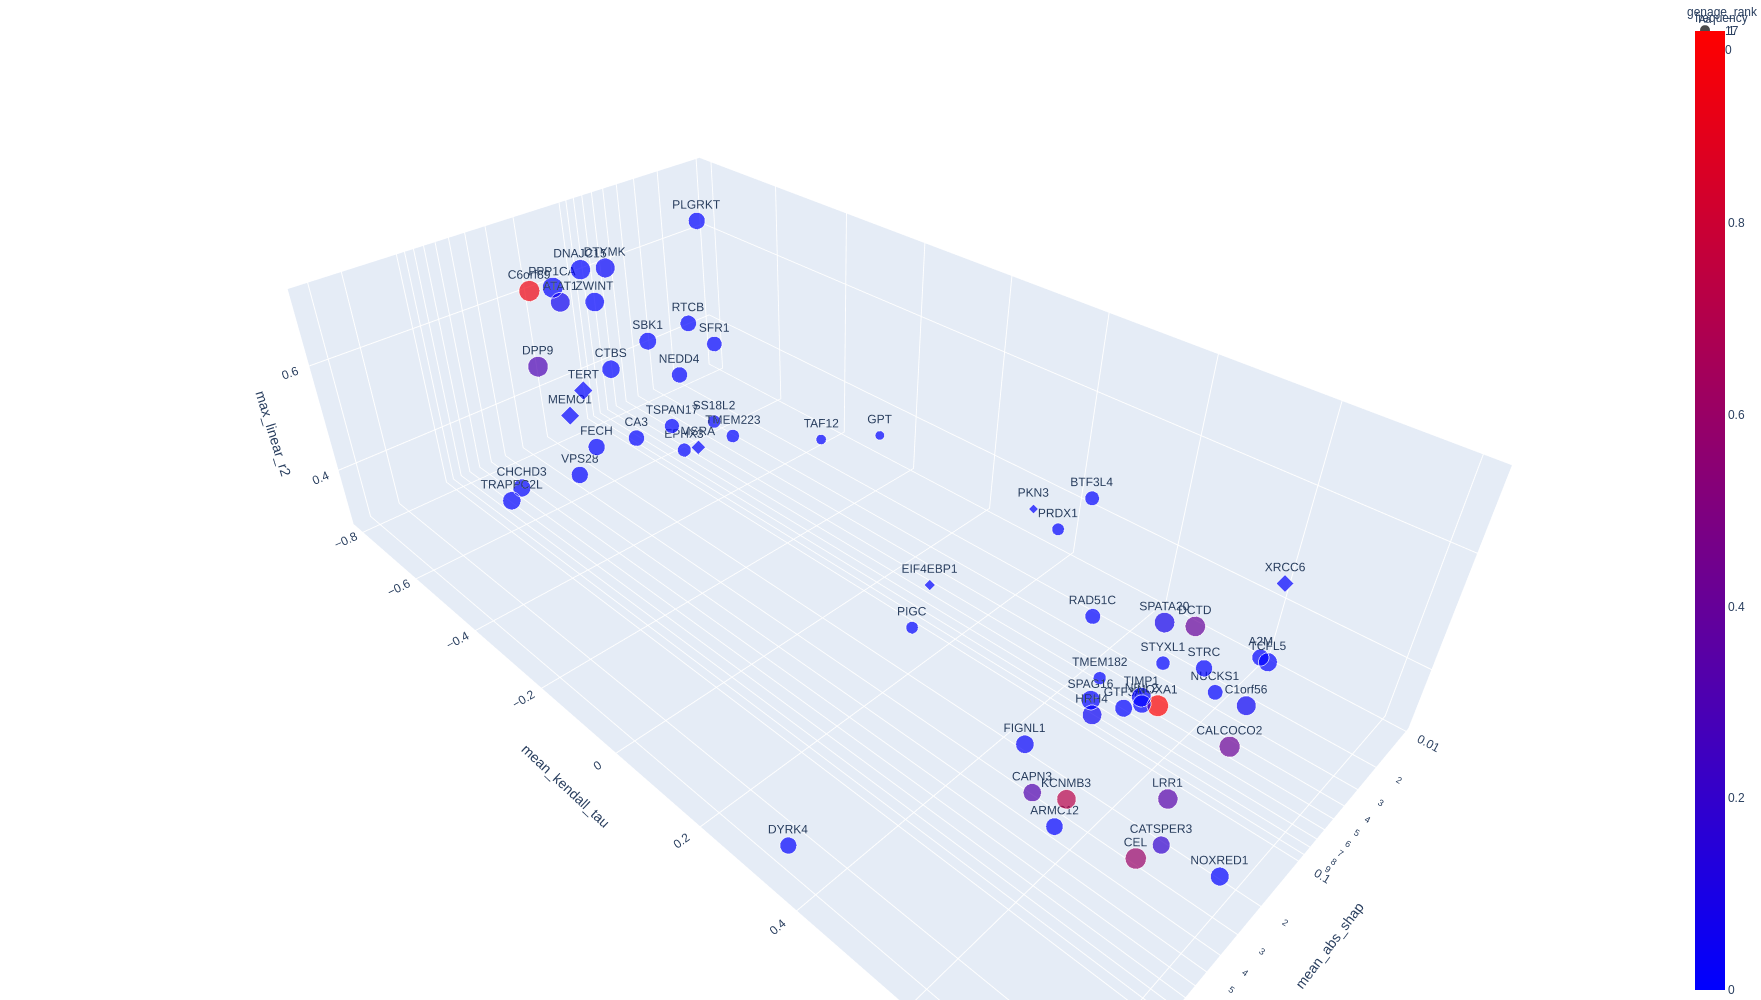

In [47]:
import plotly.express as px
fig = px.scatter_3d(for_plot_3d, x="mean_abs_shap", y="mean_kendall_tau", z="max_linear_r2", log_x=True, color_continuous_scale="Bluered",
              color='frequency', size="ranking",  opacity=0.7, text = "symbol", width=1800, height=1000, symbol="genage_rank")

# tight layout
#fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(scene = dict(
                    #xaxis =  dict(showbackground=False),
                    #yaxis = dict(showbackground=False),
                    #zaxis = dict(showbackground=False),
                 ),                  
                   margin=dict(r=0, l=0, b=0, t=0)
                 )